In [11]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


## Repeat Rutter & Dekker et al 2024 analysis

In [12]:
# Import and format the data

def get_data(input_data):
    # Read the CSV file
    d = pd.read_csv(input_data)

    # Adjust for data size and number of species as necessary
    # Here we take only time course up to t=400
    X1_bar = d.iloc[1:21, 1:5].mean(axis=1)

    # Calculate the mean of the second species
    X2_bar = d.iloc[1:21, 5:9].mean(axis=1)

    # Combine the first column with the calculated means
    obs = pd.DataFrame({
        'time': d.iloc[1:21, 0],
        'X1_bar': X1_bar,
        'X2_bar': X2_bar
    })

    # Replace negative values with 0
    obs[obs < 0] = 0

    return obs

PM3_EntA_data = get_data('PM3-EntA-coculture.csv')

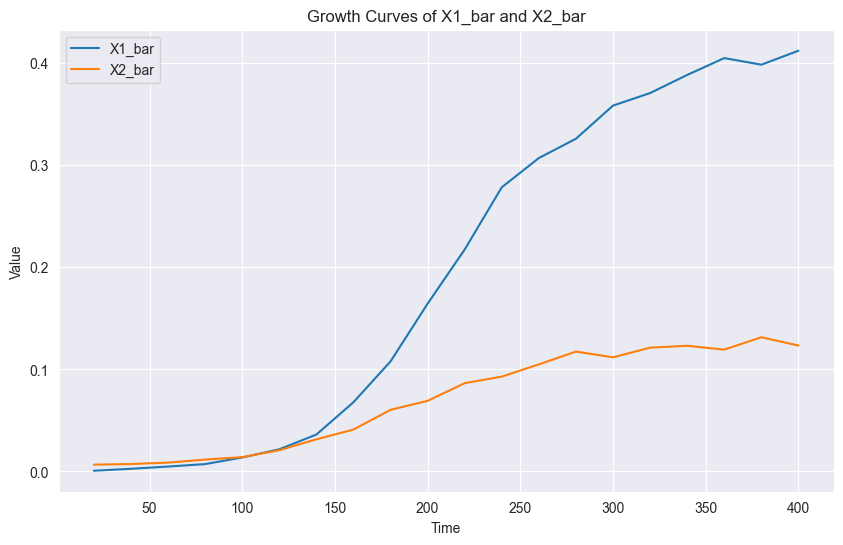

In [13]:
# Visualise the mean of the growth curves of both species grown in co-culture together
plot_growth_curves(PM3_EntA_data)

In [14]:
# Extract data and convert to numpyarrays

yobsdf = PM3_EntA_data.iloc[:, [1,2]]
yobs = yobsdf.to_numpy()
timesa = PM3_EntA_data.iloc[:, 0]
times = timesa.to_numpy()

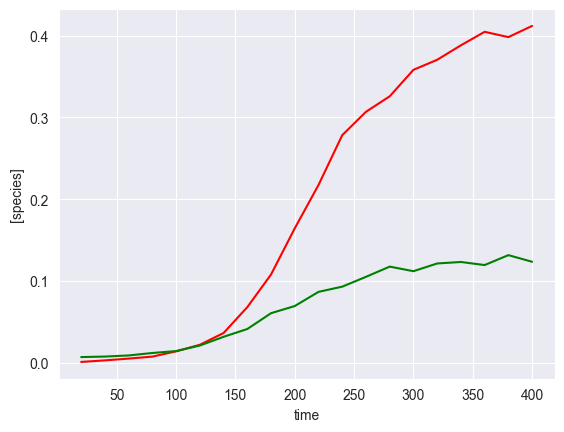

In [15]:
plot_gLV(yobs, times)

In [16]:
X, F = linearize_time_course_16S(yobs, times)

In [17]:
# Perform Bayesian inference without shrinkage

# Define priors
prior_mu_mean = 0.03
prior_mu_sigma = 0.5

## NB prior_Mij_mean is 0, so not defined as an argument
prior_Mii_mean =  0.1
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()


X shape: (19, 3)
F shape: (19, 2)
Number of species: 2
AdvancedSetSubtensor.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


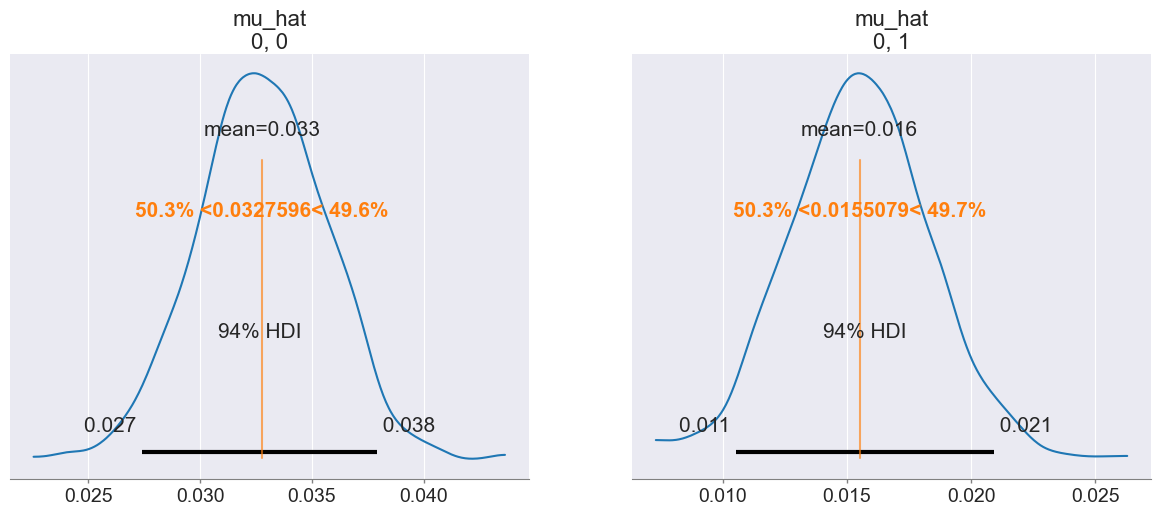

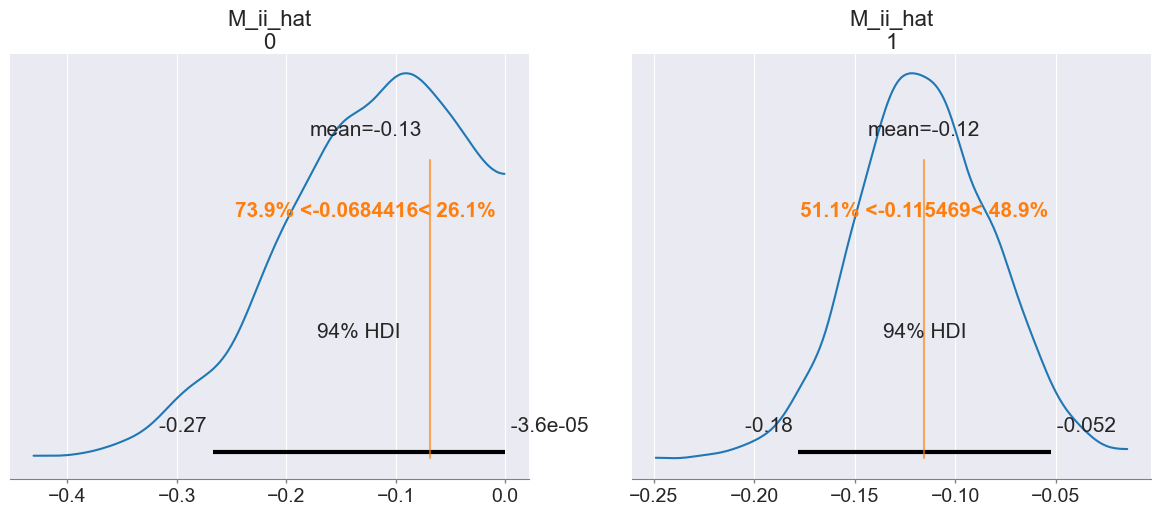

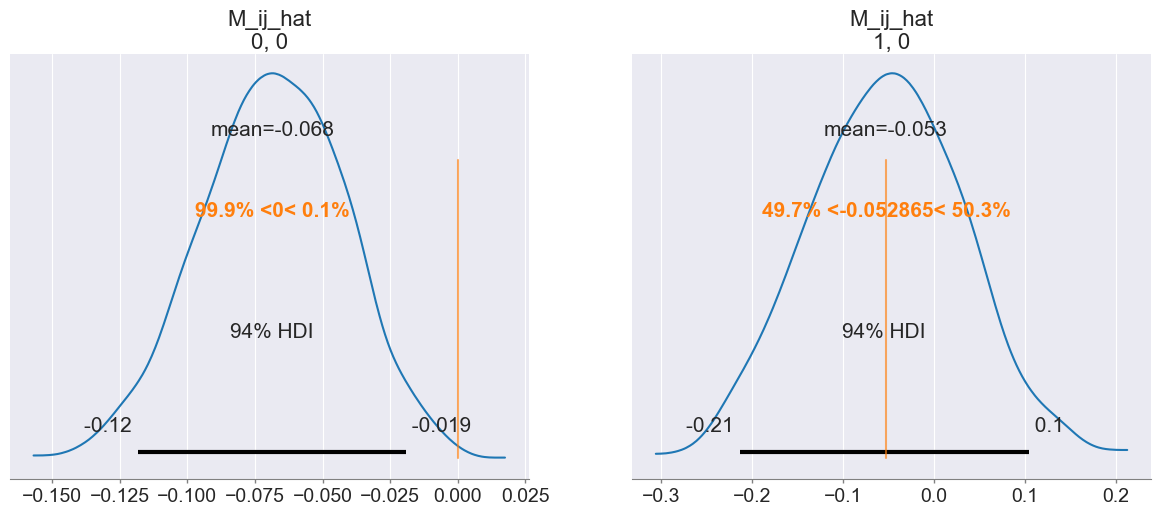

In [18]:
# To plot posterior distributions
inference.plot_posterior(idata)

In [9]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.033  0.003   1.00
mu_hat[0, 1]    0.015  0.003   1.00
M_ii_hat[0]    -0.126  0.079   1.00
M_ii_hat[1]    -0.115  0.035   1.00
M_ij_hat[0, 0] -0.070  0.027   1.00
M_ij_hat[1, 0] -0.050  0.086   1.01
M_hat[0, 0]    -0.070  0.027   1.00
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]    -0.050  0.086   1.01
M_hat[1, 1]    -0.115  0.035   1.00
sigma[0]        0.007  0.001   1.00


'model_posterior.nc'

Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03277199, 0.01541276]), 'M': array([[-0.07078901,  0.        ],
       [-0.04852345, -0.11394641]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


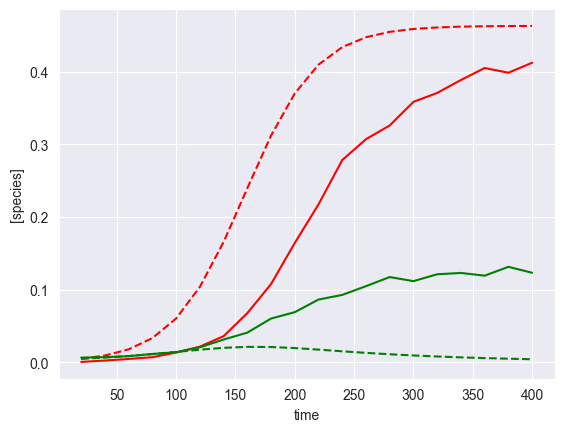

In [10]:
# To compare predicted and observed curves

init_species_start = 0.005
sim_gLV_class = sim_gLV()
curve_compare(idata, F, times, yobs, init_species_start, sim_gLV_class)

## Perform Bayesian inference with shrinkage

In [17]:
# Define priors
prior_mu_mean = 0.03
prior_mu_sigma = 0.5

prior_Mii_mean =  0.1
prior_Mii_sigma = 0.1

## NB prior_Mij_mean is 0, so not defined as an argument
prior_Mij_sigma = 0.1

# Define parameters for shrinkage on M_ij (non diagonal elements)
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

DA = nX*nX - nX

DA0 = 1     # expected number of non zero entries in M_ij
N = n_obs - 2


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

# Run inference

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference_shrinkage()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, c2, tau, lam, M_ij_hat]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━  37% 0:00:05 / 0:00:05

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
There were 314 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [18]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

                 mean     sd  r_hat
mu_hat[0, 0]    0.033  0.004   1.08
mu_hat[0, 1]    0.014  0.004   1.23
M_ii_hat[0]    -0.127  0.075   1.16
M_ii_hat[1]    -0.102  0.040   1.17
M_ij_hat[0, 0] -0.059  0.068   1.04
M_ij_hat[1, 0] -0.086  0.236   1.07
M_hat[0, 0]    -0.059  0.068   1.04
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]    -0.086  0.236   1.07
M_hat[1, 1]    -0.102  0.040   1.17
sigma[0]        0.007  0.001   1.05


/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


'model_posterior.nc'

Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03230395, 0.01461253]), 'M': array([[-0.08942369,  0.        ],
       [ 0.02417636, -0.10401031]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


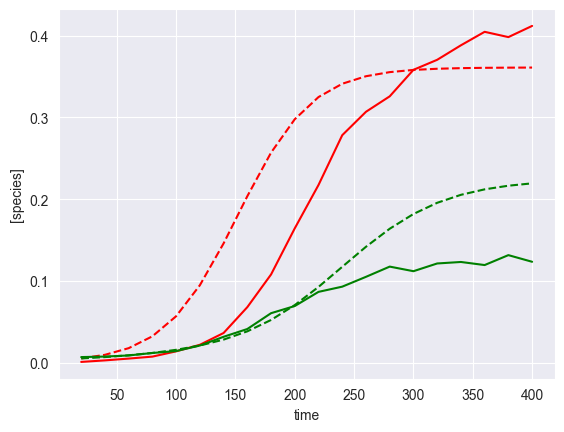

In [19]:
init_species_start = 0.005
sim_gLV_class = sim_gLV()
curve_compare(idata, F, times, yobs, init_species_start, sim_gLV_class)